In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [4]:
ten_stocks_close = pd.read_csv('Top 10 stocks.csv')

In [5]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [6]:
close_price = ten_stocks_close['002302.XSHE'].dropna()

## Ljung Box Test on close price

In [8]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,10604.717778,0.0


## Stationarity on close price first

In [9]:
test_stationarity(close_price) # p-value is larger than 0.05. Has unit root

Results of Dickey-Fuller Test:
Test Statistic                  -2.452243
p-value                          0.127531
#Lags Used                      11.000000
Number of Observations Used    988.000000
Critical Value (1%)             -3.436986
Critical Value (5%)             -2.864470
Critical Value (10%)            -2.568330
dtype: float64


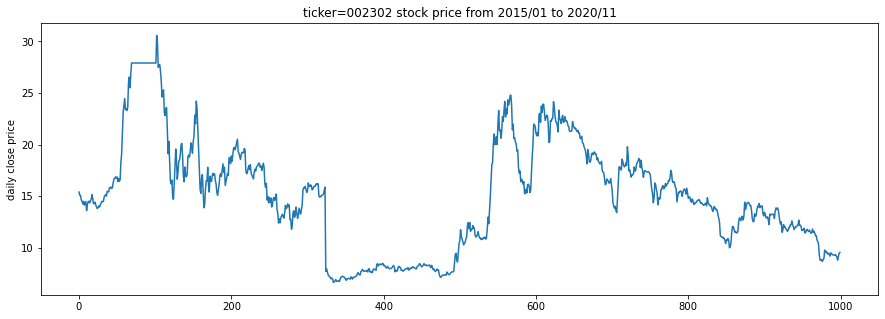

In [10]:
# visualize daily close data, lable y = column 1, ticker = 002302
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=002302 stock price from 2015/01 to 2020/11')
plt.show()

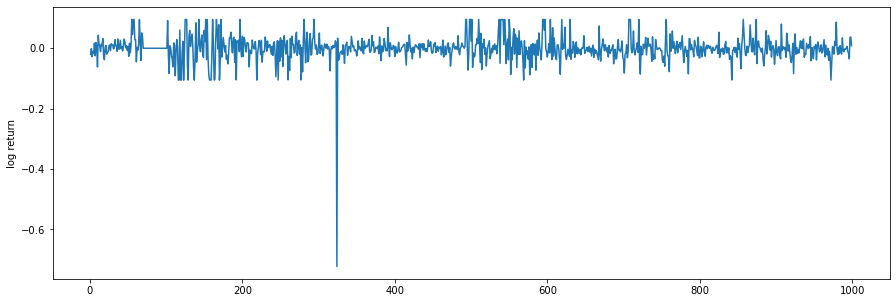

In [11]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [11]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                 -29.551125
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


## ACF & PACF

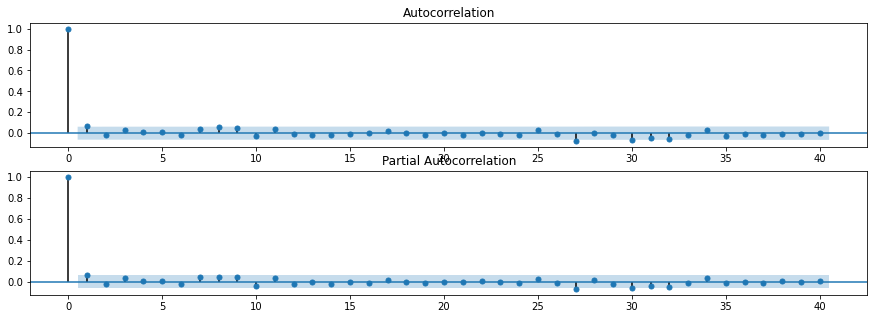

In [12]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

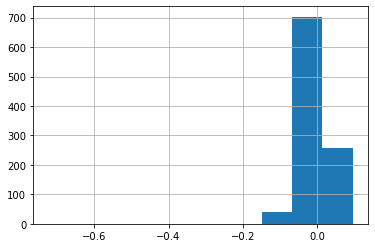

In [13]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [14]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    p = param[0]
    q = param[1]
    model = ARIMA(log_rtn, order=(p,0,q))
    
    model_fit = model.fit(disp=0)
    
    ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12], return_df=True).values[0][1]
    aic = model_fit.aic
    return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

,p,q,ljung_p,aic
5,1.0,1.0,0.633859,-3473.050921
0,0.0,1.0,0.483026,-3472.699672
4,1.0,0.0,0.469003,-3472.488960
10,2.0,1.0,0.749833,-3472.021825
6,1.0,2.0,0.749784,-3472.016689
17,3.0,3.0,0.753383,-3471.809859
1,0.0,2.0,0.511429,-3471.237605
9,2.0,0.0,0.498650,-3471.015935
11,2.0,2.0,0.832072,-3470.965937
2,0.0,3.0,0.602373,-3470.495111


## GARCH

In [13]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

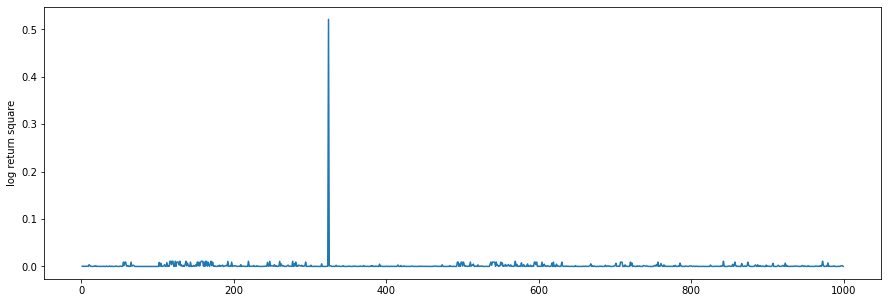

In [14]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [15]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 1.0
Conclusion: No ARCH's property in log rtn
